In [77]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split

In [78]:
df = pd.read_csv("../dataset/usage_train.csv")
df_val = pd.read_csv("../dataset/usage_validation.csv")
df_test = pd.read_csv("../dataset/usage_test.csv")
df.loc[(df['Daily_Usage_Liters'] <= 130) , 'Anomaly_Flag'] = 1
df_val.loc[(df_val['Daily_Usage_Liters'] <= 130) , 'Anomaly_Flag'] = 1
df_test.loc[(df_test['Daily_Usage_Liters'] <= 130), 'Anomaly_Flag'] = 1
df.loc[(df['Daily_Usage_Liters'] >= 400) & (df['Anomaly_Flag'] == 1), 'Anomaly_Flag'] = 0
df_val.loc[(df_val['Daily_Usage_Liters'] >= 400) & (df_val['Anomaly_Flag'] == 1), 'Anomaly_Flag'] = 0
df_test.loc[(df_test['Daily_Usage_Liters'] >= 400) & (df_test['Anomaly_Flag'] == 1), 'Anomaly_Flag'] = 0

df[df['Anomaly_Flag'] == 1].count()

Household_ID            101
Ward                    101
Address                 101
Locality                101
Day                     101
Daily_Usage_Liters      101
Anomaly_Flag            101
Leakage_Flag            101
Monthly_Usage_Liters    101
Average_Daily_Usage     101
dtype: int64

In [79]:
def assign_pressure(row):
    if row['Anomaly_Flag'] == 1:
        # Random pressure between 0.5 and 1 MPa
        return np.random.uniform(0.1, 0.5)
    else:
        # Random pressure between 1.5 and 10 MPa
        return np.random.uniform(1.5, 10.0)

# Apply the function to the DataFrame
df['Pressure(MPA)'] = df.apply(assign_pressure, axis=1)
df_val['Pressure(MPA)'] = df_val.apply(assign_pressure, axis=1)
df_test['Pressure(MPA)'] = df_test.apply(assign_pressure, axis=1)
df[df['Anomaly_Flag']==1]


,Household_ID,Ward,Address,Locality,Day,Daily_Usage_Liters,Anomaly_Flag,Leakage_Flag,Monthly_Usage_Liters,Average_Daily_Usage,Pressure(MPA)
10,345,Ward-8,"345 Sneh Nagar Street, Indore",Sneh Nagar,11,99.072161,1,1,8230.637410,274.354580,0.143040
27,282,Ward-9,"282 Rajendra Nagar Street, Indore",Rajendra Nagar,11,111.814309,1,0,7615.934914,253.864497,0.226459
282,251,Ward-8,"251 Annapurna Street, Indore",Annapurna,7,115.547874,1,0,7506.069441,250.202315,0.378232
305,36,Ward-10,"36 MG Road Street, Indore",MG Road,8,105.187231,1,0,7912.866168,263.762206,0.243160
325,210,Ward-6,"210 Sudama Nagar Street, Indore",Sudama Nagar,8,116.271644,1,0,7341.273587,244.709120,0.483809
...,...,...,...,...,...,...,...,...,...,...,...
10994,26,Ward-10,"26 Mhow Street, Indore",Mhow,21,123.533128,1,0,7434.496718,247.816557,0.174210
11024,200,Ward-2,"200 Old Palasia Street, Indore",Old Palasia,20,125.608897,1,0,7391.905505,246.396850,0.263696
11224,383,Ward-3,"383 Saket Nagar Street, Indore",Saket Nagar,27,123.827132,1,0,7085.263862,236.175462,0.140573
11754,388,Ward-1,"388 Scheme No. 54 Street, Indore",Scheme No. 54,28,125.332498,1,0,7133.066112,237.768870,0.389685


In [80]:
scaler  =   StandardScaler()
df_scaled = (df[['Daily_Usage_Liters', 'Pressure(MPA)']])
df_val_scaled= (df_val[['Daily_Usage_Liters', 'Pressure(MPA)']])
df_test_scaled = (df_test[['Daily_Usage_Liters', 'Pressure(MPA)']])

In [81]:
y_val = df_val['Anomaly_Flag']
y_test = df_test['Anomaly_Flag']
df_scaled

,Daily_Usage_Liters,Pressure(MPA)
0,275.512099,9.668489
1,338.459904,8.578034
2,254.678492,8.634474
3,164.437877,3.123080
4,327.375260,6.028409
...,...,...
11995,254.554680,4.426207
11996,277.924226,5.744395
11997,209.455303,4.136559
11998,270.912628,6.536401


In [82]:

model = IsolationForest(contamination=0.1, n_estimators=100, max_samples='auto', random_state=42)
model.fit(df_scaled)

c:\Users\bindu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.1, random_state=42)

In [83]:
df_val_predict = model.predict(df_val_scaled)
df_val_predict = [1 if pred == -1 else 0 for pred in df_val_predict]
  # Convert -1 (anomaly) to 1, and 1 (normal) to 0

In [84]:
print("Validation Data Classification Report")
print(classification_report(y_val, df_val_predict))

Validation Data Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1479
           1       0.13      1.00      0.23        21

    accuracy                           0.91      1500
   macro avg       0.57      0.95      0.59      1500
weighted avg       0.99      0.91      0.94      1500



In [85]:
test_predictions = model.predict(df_test_scaled)
test_predictions = [1 if pred == -1 else 0 for pred in test_predictions]

In [86]:
print("Test Data Classification Report")
print(classification_report(y_test, test_predictions))

Test Data Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1493
           1       0.04      1.00      0.09         7

    accuracy                           0.90      1500
   macro avg       0.52      0.95      0.52      1500
weighted avg       1.00      0.90      0.94      1500



In [87]:
val_f1_score = f1_score(y_val, df_val_predict )
test_f1_score = f1_score(y_test, test_predictions)

In [88]:
print(f"Validation F1 Score: {val_f1_score}")
print(f"Test F1 Score: {test_f1_score}")

Validation F1 Score: 0.23463687150837986
Test F1 Score: 0.08588957055214723


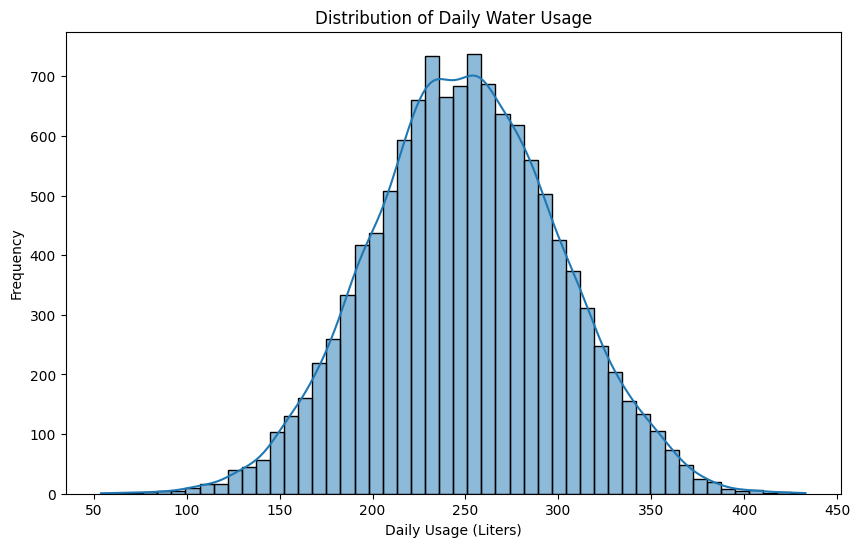

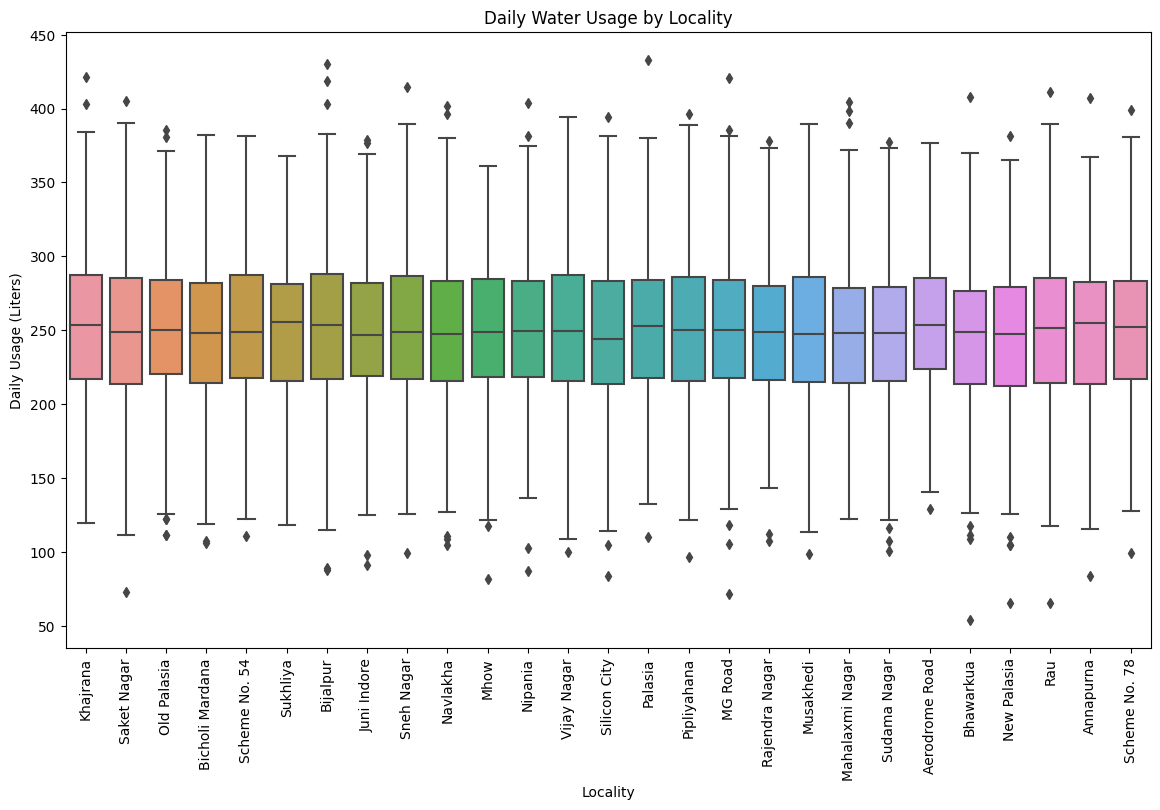

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('../dataset/usage_train.csv')

# Distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Daily_Usage_Liters'], bins=50, kde=True)
plt.title('Distribution of Daily Water Usage')
plt.xlabel('Daily Usage (Liters)')
plt.ylabel('Frequency')
plt.show()

# Box plot by locality
plt.figure(figsize=(14, 8))
sns.boxplot(x='Locality', y='Daily_Usage_Liters', data=df)
plt.title('Daily Water Usage by Locality')
plt.xlabel('Locality')
plt.ylabel('Daily Usage (Liters)')
plt.xticks(rotation=90)
plt.show()
